Ê∏¨Ë©¶ÂèÉÊï∏: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.9}
F1-score (label=1): 0.2526
Ê∏¨Ë©¶ÂèÉÊï∏: {'max_depth': 6, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 1.0}
F1-score (label=1): 0.2887
Ê∏¨Ë©¶ÂèÉÊï∏: {'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 150, 'subsample': 0.8}
F1-score (label=1): 0.2922
ÊúÄ‰Ω≥Ê®°ÂûãË©ï‰º∞:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18413
           1       0.83      0.18      0.29       327

    accuracy                           0.99     18740
   macro avg       0.91      0.59      0.64     18740
weighted avg       0.98      0.99      0.98     18740

MAE: 0.014994663820704376
MSE: 0.014994663820704376
R^2: 0.1254118259420155


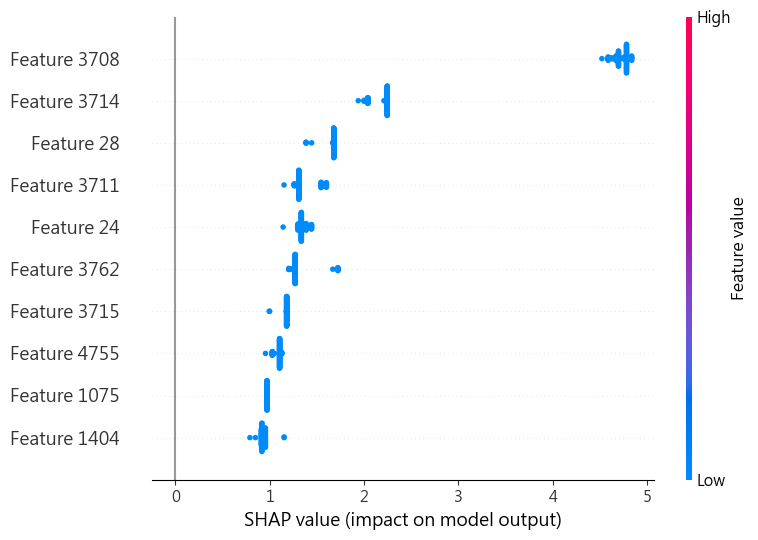

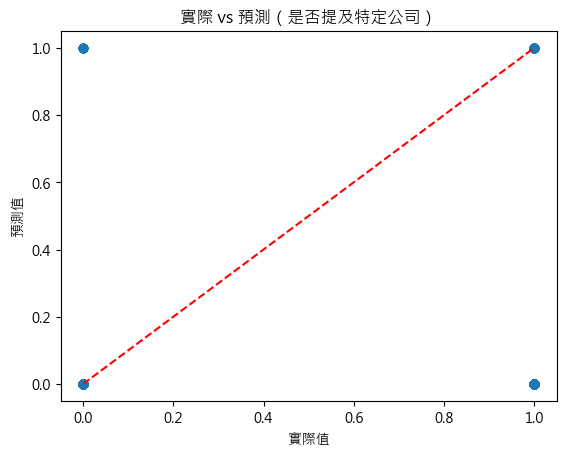

In [10]:
# ÂÆåÊï¥ÂÑ™ÂåñÁâàÔºöTF-IDF + XGBoost + SHAP + ÁâπÂæµÂ∑•Á®ã + Ëá™Ë®ÇÂèÉÊï∏Ë™øÊï¥ + Ê®°ÂûãÂÑ≤Â≠ò
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

# Ëß£Ê±∫‰∏≠Êñá‰∫ÇÁ¢º
matplotlib.rcParams['font.family'] = 'Microsoft JhengHei'

# ËºâÂÖ•Ë≥áÊñô
mobile_df = pd.read_csv("mobile01_ËôïÁêÜÂæå.csv")
ptt_df = pd.read_csv("ptt_Ë™ûÊñô_ËôïÁêÜÂæå.csv")

# Âä†‰∏äÂπ≥Âè∞Ê¨Ñ‰ΩçËàáÁµ±Êï¥ÊñáÂ≠ó
mobile_df['Âπ≥Âè∞'] = 'Mobile01'
ptt_df['Âπ≥Âè∞'] = 'PTT'
mobile_df['text'] = mobile_df['ÁïôË®ÄÂÖßÂÆπ'].fillna('') + ' ' + mobile_df['ÁôºÊñáÂÖßÂÆπ'].fillna('')
ptt_df['text'] = ptt_df['ÁïôË®ÄÂÖßÂÆπ'].fillna('') + ' ' + ptt_df['ÁôºÊñáÂÖßÂÆπ'].fillna('')

# Âêà‰ΩµË≥áÊñô
combined_df = pd.concat([
    mobile_df[['Âπ≥Âè∞', 'text', 'Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏', '‰øùÈö™ÈóúÈçµË©ûÊ¨°Êï∏', 'ÊòØÂê¶‰∏ªÊñá', 'ÊòØÂê¶ÊèêÂèäÁâπÂÆöÂÖ¨Âè∏']],
    ptt_df[['Âπ≥Âè∞', 'text', 'Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏', '‰øùÈö™ÈóúÈçµË©ûÊ¨°Êï∏', 'ÊòØÂê¶‰∏ªÊñá', 'ÊòØÂê¶ÊèêÂèäÁâπÂÆöÂÖ¨Âè∏']]
], ignore_index=True)

# Âä†ÂÖ•ÈÄ≤ÈöéÁâπÂæµ
combined_df['ÊñáÂ≠óÈï∑Â∫¶'] = combined_df['text'].apply(len)
combined_df['ÈóúÈçµË©ûÁ∏ΩÊï∏'] = combined_df['Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏'] + combined_df['‰øùÈö™ÈóúÈçµË©ûÊ¨°Êï∏']
combined_df['ÊòØÂê¶‰∏ªÊñá'] = combined_df['ÊòØÂê¶‰∏ªÊñá'].astype(int)
le = LabelEncoder()
combined_df['Âπ≥Âè∞Á∑®Á¢º'] = le.fit_transform(combined_df['Âπ≥Âè∞'])

# ÁâπÂæµËôïÁêÜ
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(combined_df['text'].astype(str))
X_other = combined_df[['Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏', '‰øùÈö™ÈóúÈçµË©ûÊ¨°Êï∏', 'ÊòØÂê¶‰∏ªÊñá', 'ÊñáÂ≠óÈï∑Â∫¶', 'ÈóúÈçµË©ûÁ∏ΩÊï∏', 'Âπ≥Âè∞Á∑®Á¢º']].reset_index(drop=True)
X = hstack([X_text, X_other])
y = combined_df['ÊòØÂê¶ÊèêÂèäÁâπÂÆöÂÖ¨Âè∏'].astype(int)

# ÂàÜÂâ≤Ë≥áÊñô
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ÊâãÂãïÂèÉÊï∏ÁµÑÂêàÊ∏¨Ë©¶
param_grid = [
    {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.9},
    {'max_depth': 6, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 1.0},
    {'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 150, 'subsample': 0.8},
]

best_f1 = 0
best_model = None

for params in param_grid:
    print(f"Ê∏¨Ë©¶ÂèÉÊï∏: {params}")
    model = XGBClassifier(eval_metric='logloss', **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['1']['f1-score']
    print(f"F1-score (label=1): {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_model = model

# È†êÊ∏¨ËàáË©ï‰º∞
final_pred = best_model.predict(X_test)
print("ÊúÄ‰Ω≥Ê®°ÂûãË©ï‰º∞:")
print(classification_report(y_test, final_pred))
print(f'MAE: {mean_absolute_error(y_test, final_pred)}')
print(f'MSE: {mean_squared_error(y_test, final_pred)}')
print(f'R^2: {r2_score(y_test, final_pred)}')

# SHAP Ëß£Èáã
X_sample = X_test[:100].toarray()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample, max_display=10)

# Ê®°ÂûãÂÑ≤Â≠ò
joblib.dump(best_model, "xgb_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Ë¶ñË¶∫Âåñ
plt.scatter(y_test, final_pred)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('ÂØ¶ÈöõÂÄº')
plt.ylabel('È†êÊ∏¨ÂÄº')
plt.title('ÂØ¶Èöõ vs È†êÊ∏¨ÔºàÊòØÂê¶ÊèêÂèäÁâπÂÆöÂÖ¨Âè∏Ôºâ')
plt.show()

c:\Users\Robby1206\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:15:30] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.58      0.43      0.50      4332
           1       0.76      0.85      0.80      9097

    accuracy                           0.72     13429
   macro avg       0.67      0.64      0.65     13429
weighted avg       0.70      0.72      0.70     13429

MAE: 0.28267182962245885
MSE: 0.28267182962245885
R^2: -0.29355004353915737


c:\Users\Robby1206\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  pl.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


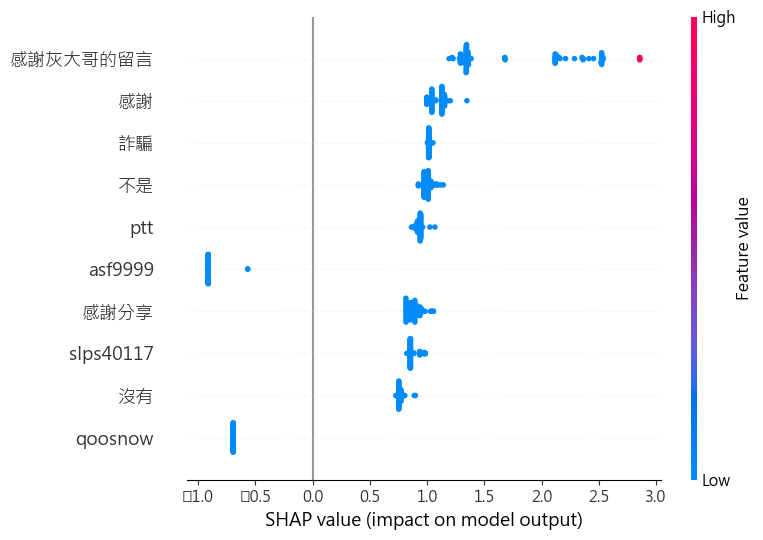

Áñë‰ººË©êÈ®ôÂ∏≥ËôüÊéíË°å:
                 Â∏≥Ëôü  È†êÊ∏¨Ê¨°Êï∏
2006       tourcura   882
3849           ÁÅ∞ÁÅ∞Â§™Áãº   485
3949  ÈÄ£‰∫∫Â∏∂Ëªä100KGÈÇÑÈ®éË∂ÖÂø´   356
1673       pigstand   355
2552         ÊàëÂ∞±ÊòØÊÑõÊãçÁÖß   220
725            cafm   200
293     LKKSPP16888   132
3996            ÈæçÊ†°Èï∑   121
486     a0918116005    87
3867           ÁîüÊ¥ªÁé©Âíñ    78


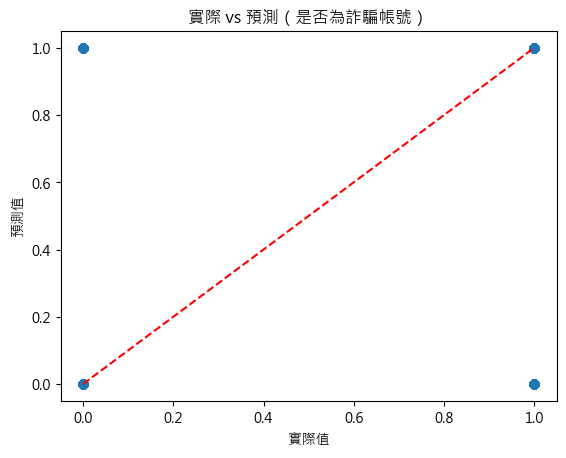

In [14]:
# Ê™¢Ê∏¨Â∏≥ËôüÊòØÂê¶ÁÇ∫Ë©êÈ®ôËÄÖÔºö‰ª•Â∏≥Ëôü + ÁôºÊñáÂÖßÂÆπ/ÁïôË®ÄÂÖßÂÆπÁÇ∫Âü∫Á§éÈÄ≤Ë°å XGBoost È†êÊ∏¨ÔºàÂèØË¶ñÂåñÂ∏≥ËôüÔºâ
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix

# Ëß£Ê±∫‰∏≠Êñá‰∫ÇÁ¢º
matplotlib.rcParams['font.family'] = 'Microsoft JhengHei'

# ËºâÂÖ•Ë≥áÊñô
mobile_df = pd.read_csv("mobile01_ËôïÁêÜÂæå.csv")
ptt_df = pd.read_csv("ptt_Ë™ûÊñô_ËôïÁêÜÂæå.csv")

# Êï¥ÂêàÂ∏≥ËôüËàáÊñáÂ≠óÂÖßÂÆπ
mobile_df['Âπ≥Âè∞'] = 'Mobile01'
ptt_df['Âπ≥Âè∞'] = 'PTT'
mobile_df['Â∏≥Ëôü'] = mobile_df['ÁïôË®ÄÂ∏≥Ëôü'].fillna(mobile_df['ÁôºÊñáËÄÖÂ∏≥Ëôü'])
ptt_df['Â∏≥Ëôü'] = ptt_df['ÁïôË®ÄÂ∏≥Ëôü'].fillna(ptt_df['ÁôºÊñáËÄÖÂ∏≥Ëôü'])
mobile_df['text'] = mobile_df['ÁïôË®ÄÂÖßÂÆπ'].fillna('') + ' ' + mobile_df['ÁôºÊñáÂÖßÂÆπ'].fillna('')
ptt_df['text'] = ptt_df['ÁïôË®ÄÂÖßÂÆπ'].fillna('') + ' ' + ptt_df['ÁôºÊñáÂÖßÂÆπ'].fillna('')

# Âêà‰ΩµË≥áÊñô
combined_df = pd.concat([
    mobile_df[['Â∏≥Ëôü', 'text', 'Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏']],
    ptt_df[['Â∏≥Ëôü', 'text', 'Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏']]
], ignore_index=True)

# Ê∏ÖÁêÜËàáÊ®ôÁ±§
combined_df = combined_df.dropna(subset=['Â∏≥Ëôü'])
combined_df = combined_df[combined_df['text'].str.strip() != '']
combined_df['label'] = (combined_df['Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏'] > 0).astype(int)

# ÁâπÂæµËΩâÊèõ
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(combined_df['text'].astype(str))
le_account = LabelEncoder()
account_encoded = le_account.fit_transform(combined_df['Â∏≥Ëôü'])
X_account = account_encoded.reshape(-1, 1)
X = hstack([X_text, csr_matrix(X_account)])
y = combined_df['label']

# ÂàÜÂâ≤Ë≥áÊñô
X_train, X_test, y_train, y_test, acc_train, acc_test = train_test_split(X, y, account_encoded, test_size=0.2, random_state=42)

# ‰ΩøÁî® XGBoost Ê®°Âûã
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Ë©ï‰º∞
print(classification_report(y_test, y_pred))
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

# SHAP Ëß£Èáã
X_sample = X_test[:100].toarray()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)
all_feature_names = vectorizer.get_feature_names_out().tolist() + ['Â∏≥ËôüÁ∑®Á¢º']
shap.summary_plot(shap_values, features=X_sample, feature_names=all_feature_names, max_display=10)

# È°ØÁ§∫È´òÈ¢®Èö™Â∏≥ËôüÈ†êÊ∏¨ÁµêÊûú
suspicious_accounts = le_account.inverse_transform(acc_test[y_pred == 1])
unique, counts = np.unique(suspicious_accounts, return_counts=True)
account_risk_df = pd.DataFrame({'Â∏≥Ëôü': unique, 'È†êÊ∏¨Ê¨°Êï∏': counts}).sort_values(by='È†êÊ∏¨Ê¨°Êï∏', ascending=False)
print("Áñë‰ººË©êÈ®ôÂ∏≥ËôüÊéíË°å:")
print(account_risk_df.head(10))

# ÂÑ≤Â≠ò
joblib.dump(model, "xgb_scam_account_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_account.pkl")
joblib.dump(le_account, "account_encoder.pkl")

# Êï£ÈªûÂúñË¶ñË¶∫Âåñ
plt.scatter(y_test, y_pred)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('ÂØ¶ÈöõÂÄº')
plt.ylabel('È†êÊ∏¨ÂÄº')
plt.title('ÂØ¶Èöõ vs È†êÊ∏¨ÔºàÊòØÂê¶ÁÇ∫Ë©êÈ®ôÂ∏≥ËôüÔºâ')
plt.show()


c:\Users\Robby1206\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:51:25] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.58      0.43      0.49      4372
           1       0.76      0.85      0.80      9120

    accuracy                           0.72     13492
   macro avg       0.67      0.64      0.65     13492
weighted avg       0.70      0.72      0.70     13492

MAE: 0.2843166320782686
MSE: 0.2843166320782686
R^2: -0.29801568193126915


c:\Users\Robby1206\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  pl.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


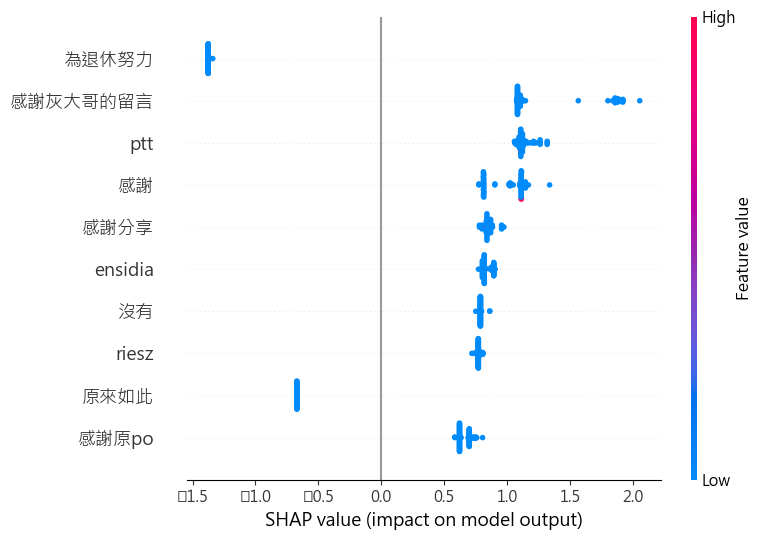

Áñë‰ººË©êÈ®ôÂ∏≥ËôüÊéíË°å:
                       Ë´ñÂ£á-Â∏≥Ëôü  È†êÊ∏¨Ê¨°Êï∏
695        Mobile01-tourcura   880
1001           Mobile01-ÁÅ∞ÁÅ∞Â§™Áãº   487
585        Mobile01-pigstand   349
1111  Mobile01-ÈÄ£‰∫∫Â∏∂Ëªä100KGÈÇÑÈ®éË∂ÖÂø´   320
932          Mobile01-ÊàëÂ∞±ÊòØÊÑõÊãçÁÖß   213
288            Mobile01-cafm   204
134     Mobile01-LKKSPP16888   140
1164            Mobile01-ÈæçÊ†°Èï∑   134
206     Mobile01-a0918116005    88
1021           Mobile01-ÁîüÊ¥ªÁé©Âíñ    83


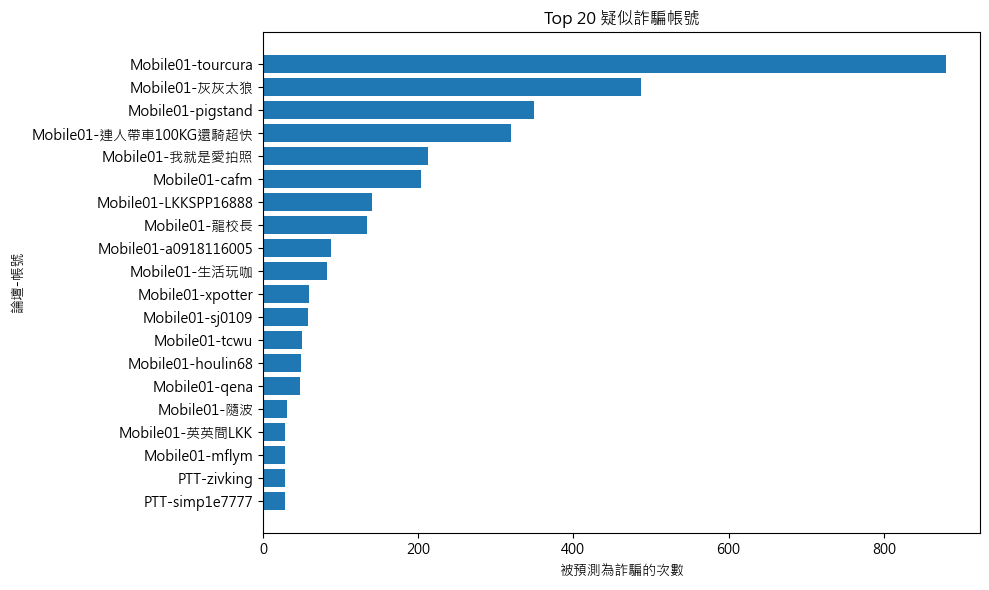

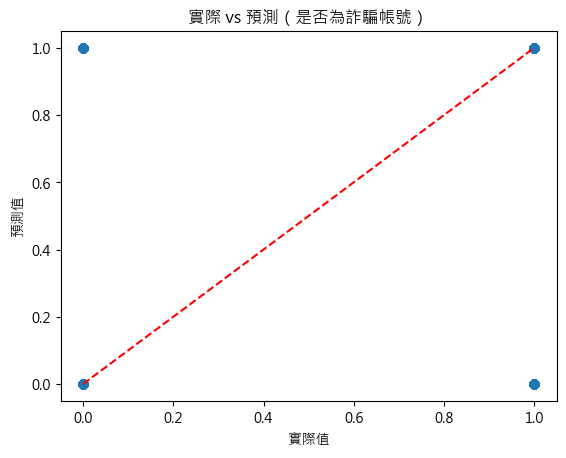

In [33]:
# Ê™¢Ê∏¨Â∏≥ËôüÊòØÂê¶ÁÇ∫Ë©êÈ®ôËÄÖÔºö‰ª•Â∏≥Ëôü + ÁôºÊñáÂÖßÂÆπ/ÁïôË®ÄÂÖßÂÆπÁÇ∫Âü∫Á§éÈÄ≤Ë°å XGBoost È†êÊ∏¨ÔºàÂèØË¶ñÂåñÂ∏≥ËôüÔºâ
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix

# Ëß£Ê±∫‰∏≠Êñá‰∫ÇÁ¢º
matplotlib.rcParams['font.family'] = 'Microsoft JhengHei'

# ËºâÂÖ•Ë≥áÊñô
mobile_df = pd.read_csv("mobile01_ËôïÁêÜÂæå.csv")
ptt_df = pd.read_csv("ptt_Ë™ûÊñô_ËôïÁêÜÂæå.csv")
finfo_df = pd.read_csv("finfo_posts_Áî¢Èö™_Â£ΩÈö™_ÊäïË≥áÂûã.csv")

# Êï¥ÂêàÂ∏≥ËôüËàáÊñáÂ≠óÂÖßÂÆπ
mobile_df['Âπ≥Âè∞'] = 'Mobile01'
ptt_df['Âπ≥Âè∞'] = 'PTT'
finfo_df['Âπ≥Âè∞'] = 'Finfo'

for df in [mobile_df, ptt_df, finfo_df]:
    if 'ÁïôË®ÄÂ∏≥Ëôü' in df.columns and 'ÁôºÊñáËÄÖÂ∏≥Ëôü' in df.columns:
        df['Â∏≥Ëôü'] = df['ÁïôË®ÄÂ∏≥Ëôü'].fillna(df['ÁôºÊñáËÄÖÂ∏≥Ëôü'])
    elif 'Â∏≥Ëôü' in df.columns:
        df['Â∏≥Ëôü'] = df['Â∏≥Ëôü']
    elif 'author' in df.columns:
        df['Â∏≥Ëôü'] = df['author']
    else:
        df['Â∏≥Ëôü'] = 'Êú™Áü•Â∏≥Ëôü'

    df['ÁïôË®ÄÂÖßÂÆπ'] = df['ÁïôË®ÄÂÖßÂÆπ'] if 'ÁïôË®ÄÂÖßÂÆπ' in df.columns else ''
    df['ÁôºÊñáÂÖßÂÆπ'] = df['ÁôºÊñáÂÖßÂÆπ'] if 'ÁôºÊñáÂÖßÂÆπ' in df.columns else ''
    df['text'] = df['ÁïôË®ÄÂÖßÂÆπ'].fillna('') + ' ' + df['ÁôºÊñáÂÖßÂÆπ'].fillna('')

    if 'Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏' not in df.columns:
        df['Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏'] = 0

# Âêà‰ΩµË≥áÊñô
combined_df = pd.concat([
    mobile_df[['Âπ≥Âè∞', 'Â∏≥Ëôü', 'text', 'Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏']],
    ptt_df[['Âπ≥Âè∞', 'Â∏≥Ëôü', 'text', 'Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏']],
    finfo_df[['Âπ≥Âè∞', 'Â∏≥Ëôü', 'text', 'Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏']]
], ignore_index=True)

# Ê∏ÖÁêÜËàáÊ®ôÁ±§
combined_df = combined_df.dropna(subset=['Â∏≥Ëôü'])
combined_df = combined_df[combined_df['text'].str.strip() != '']
combined_df['label'] = (combined_df['Ë©êÈ®ôÈóúÈçµË©ûÊ¨°Êï∏'] > 0).astype(int)

# ÁâπÂæµËΩâÊèõ
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(combined_df['text'].astype(str))
le_account = LabelEncoder()
account_encoded = le_account.fit_transform(combined_df['Â∏≥Ëôü'])
X_account = account_encoded.reshape(-1, 1)
X = hstack([X_text, csr_matrix(X_account)])
y = combined_df['label']

# ÂàÜÂâ≤Ë≥áÊñô
X_train, X_test, y_train, y_test, acc_train, acc_test, platform_train, platform_test = train_test_split(
    X, y, account_encoded, combined_df['Âπ≥Âè∞'].values, test_size=0.2, random_state=42)

# ‰ΩøÁî® XGBoost Ê®°Âûã
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Ë©ï‰º∞
print(classification_report(y_test, y_pred))
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

# SHAP Ëß£Èáã
X_sample = X_test[:100].toarray()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)
all_feature_names = vectorizer.get_feature_names_out().tolist() + ['Â∏≥ËôüÁ∑®Á¢º']
shap.summary_plot(shap_values, features=X_sample, feature_names=all_feature_names, max_display=10)

# È°ØÁ§∫È´òÈ¢®Èö™Â∏≥ËôüÈ†êÊ∏¨ÁµêÊûúÔºàÂê´Âπ≥Âè∞Ôºâ
suspicious_accounts = le_account.inverse_transform(acc_test[y_pred == 1])
suspicious_platforms = platform_test[y_pred == 1]
account_platform_combo = [f"{p}-{a}" for p, a in zip(suspicious_platforms, suspicious_accounts)]
unique, counts = np.unique(account_platform_combo, return_counts=True)
account_risk_df = pd.DataFrame({'Ë´ñÂ£á-Â∏≥Ëôü': unique, 'È†êÊ∏¨Ê¨°Êï∏': counts}).sort_values(by='È†êÊ∏¨Ê¨°Êï∏', ascending=False)
print("Áñë‰ººË©êÈ®ôÂ∏≥ËôüÊéíË°å:")
print(account_risk_df.head(10))

# Èï∑Ê¢ùÂúñË¶ñË¶∫ÂåñÔºàÂä†‰∏äÂπ≥Âè∞Ôºâ
top_n = 20
top_accounts = account_risk_df.head(top_n)
plt.figure(figsize=(10, 6))
plt.barh(top_accounts['Ë´ñÂ£á-Â∏≥Ëôü'], top_accounts['È†êÊ∏¨Ê¨°Êï∏'])
plt.xlabel('Ë¢´È†êÊ∏¨ÁÇ∫Ë©êÈ®ôÁöÑÊ¨°Êï∏')
plt.ylabel('Ë´ñÂ£á-Â∏≥Ëôü')
plt.title(f'Top {top_n} Áñë‰ººË©êÈ®ôÂ∏≥Ëôü')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ÂÑ≤Â≠ò
joblib.dump(model, "xgb_scam_account_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_account.pkl")
joblib.dump(le_account, "account_encoder.pkl")

# Êï£ÈªûÂúñ
plt.scatter(y_test, y_pred)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('ÂØ¶ÈöõÂÄº')
plt.ylabel('È†êÊ∏¨ÂÄº')
plt.title('ÂØ¶Èöõ vs È†êÊ∏¨ÔºàÊòØÂê¶ÁÇ∫Ë©êÈ®ôÂ∏≥ËôüÔºâ')
plt.show()

In [ ]:
# ‰Ω†ÊèêÂà∞ÁöÑ R¬≤ = -0.29 ÁöÑÁ¢∫ÂÅè‰ΩéÔºå‰ΩÜÈÄôÊòØÂõ†ÁÇ∫ R¬≤ ‰∏çÈÅ©ÂêàÁî®‰æÜË©ï‰º∞ÂàÜÈ°û‰ªªÂãôÔºàÂÉèÈÄôÂÄã„ÄåÊòØÂê¶ÁÇ∫Ë©êÈ®ôÂ∏≥Ëôü„ÄçÊòØ‰∫åÂÖÉÂàÜÈ°ûÔºâ„ÄÇ‰æÜÁ∞°ÂñÆËß£Êûê‰∏Ä‰∏ãÔºö

# üìå ÁÇ∫‰ªÄÈ∫º R¬≤ Âú®ÈÄôË£°‰∏çÊ∫ñÔºü
# R¬≤ ÊòØÂõûÊ≠∏Áî®ÁöÑÊåáÊ®ôÔºåÁî®‰æÜË°°Èáè„ÄåÊ®°ÂûãÈ†êÊ∏¨ÂÄº„ÄçËàá„ÄåÂØ¶ÈöõÈÄ£Á∫åÊï∏ÂÄº„ÄçÁöÑÂÅèÂ∑Æ„ÄÇ

# ‰Ω†ÁèæÂú®ÊòØÂàÜÈ°ûÂïèÈ°åÔºåy ÊòØ 0 Êàñ 1ÔºåËÄå‰∏çÊòØÈÄ£Á∫åÊï∏ÂÄº„ÄÇ

# ÊâÄ‰ª•ÈÄôÈÇä R¬≤ < 0 Âè™ÊòØ‰ª£Ë°®„ÄåÊãøÂÆÉ‰æÜÂàÜÈ°û‰ªªÂãôÊòØÈåØË™§‰ΩøÁî®„Äç„ÄÇ

# ‚úÖ Ê≠£Á¢∫ÁöÑÂàÜÈ°ûË©ï‰º∞ÊåáÊ®ô
# AccuracyÔºöÊï¥È´îÊ≠£Á¢∫Áéá ‚Üí 72%Ôºà‰∏çÈåØÔºâ

# Recall (class=1)ÔºöÊäìÂá∫Ë©êÈ®ôÁöÑÊØîÁéá ‚Üí 85%ÔºàÂæàÂ•ΩÔºâ

# Precision (class=1)Ôºö‰Ω†ÊäìÂà∞ÁöÑÊúâÂ§öÂ∞ëÊòØÁúüÁöÑ ‚Üí 76%Ôºà‰∏çÈåØÔºâ

# F1-scoreÔºöÁ≤æÊ∫ñËàáÂè¨ÂõûÁöÑÁ∂úÂêà ‚Üí 0.80ÔºàÂæàÂØ¶Áî®Ôºâ

# üéØ ‰ªÄÈ∫ºÊôÇÂÄô R¬≤ ÊâçÊúÉÈáçË¶ÅÔºü
# Áï∂‰Ω†ÂÅöÁöÑ‰ªªÂãôÊòØÔºö

# È†êÊ∏¨ÂÉπÊ†º„ÄÅÂàÜÊï∏„ÄÅ‰ΩøÁî®ÊôÇÈñìÁ≠â„ÄåÈÄ£Á∫åÊï∏ÂÄº„Äç

# ÊâçÈÅ©ÂêàÁúã MAE, MSE, R¬≤

# ‚úÖ Âª∫Ë≠∞
# ‰Ω†ÂèØ‰ª•Áõ¥Êé•Âà™Èô§ R¬≤ ÁöÑ print Ë°åÔºåÂè™Áïô‰∏ã classification_report Â∞±Â§†Áî®‰∫Ü„ÄÇ Ë¶ÅÊàëÂπ´‰Ω†‰øÆÊîπÁ®ãÂºèÔºåÊää‰∏çÂøÖË¶ÅÁöÑÊåáÊ®ôÁßªÈô§ÂóéÔºüÊàñËÄÖË¶ÅÂä†‰∏ä AUCÔºàÊõ¥ÈÅ©ÂêàË©êÈ®ôÊ™¢Ê∏¨ÔºâÔºü

In [ ]:
# SHAP ÂÄºÁ∏ΩÂíåÊéíÂêçÔºàÂâç 30 ÁâπÂæµÔºâ
mean_shap = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(mean_shap)[::-1][:30]
top_features = [(all_feature_names[i], mean_shap[i]) for i in top_indices]
df_top_features = pd.DataFrame(top_features, columns=["ÁâπÂæµ", "Âπ≥Âùá SHAP ÂÄº"])
print("ÈáçË¶ÅÁâπÂæµÊéíÂêçÔºàÊ†πÊìö SHAPÔºâ:")
print(df_top_features)

ÈáçË¶ÅÁâπÂæµÊéíÂêçÔºàÊ†πÊìö SHAPÔºâ:
               ÁâπÂæµ  Âπ≥Âùá SHAP ÂÄº
0        ÊÑüË¨ùÁÅ∞Â§ßÂì•ÁöÑÁïôË®Ä   1.711383
1              ÊÑüË¨ù   1.097168
2              Ë©êÈ®ô   1.015389
3              ‰∏çÊòØ   1.008077
4             ptt   0.927583
5         asf9999   0.904013
6            ÊÑüË¨ùÂàÜ‰∫´   0.883132
7       slps40117   0.871569
8              Ê≤íÊúâ   0.762287
9         qoosnow   0.692985
10             ÊÅïÂà™   0.680342
11      dopeyaeen   0.655244
12             ÊäïË≥á   0.633041
13       zzzzaaaa   0.606612
14      chenjunfa   0.538419
15        ÊàëÁü•ÈÅì‰Ω†ÈÇÑÊúâÈå¢   0.535620
16       omega162   0.534291
17  jiangbruce888   0.529553
18          ÊÑüË¨ùÂéüpo   0.520462
19          ÊäïË≥áÂàùÂ≠∏ËÄÖ   0.515634
20             ps   0.499327
21            Áî®‰∏çÂà∞   0.493388
22             30   0.473251
23      redbeanss   0.441744
24             ÈáëËûç   0.441326
25             ‰∏çÊúÉ   0.437159
26          xlove   0.436548
27             ÂÆöÂ≠ò   0.434727
28         nlevt

In [5]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install lightGBM


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
print(merged_df.columns.tolist())

['Â∏≥Ëôü', 'Â∏≥ËôüÂá∫ÁèæÊ¨°Êï∏', 'ÊòØÂê¶ÂáåÊô®', 'ÊòØÂê¶Âê´Ë©êÈ®ôÂ≠óË©û', 'ÂÖßÂÆπÈï∑Â∫¶', 'ÊòØÂê¶‰∏ªÊñá', '‰æÜÊ∫ê_ptt-gossiping-ÂõûÊñá', '‰æÜÊ∫ê_ptt-insurance-ÂõûÊñá', '‰æÜÊ∫ê_ptt-lifeismoney-ÂõûÊñá', '‰æÜÊ∫ê_ptt-stock-ÂõûÊñá', '‰æÜÊ∫ê_ptt-womentalk-ÂõûÊñá', 'isolation_anomaly_score', 'svm_anomaly_score', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '101', '106', '11', '111', '112', '114', '116', '118', '12', '123', '125', '13', '136', '137', '138', '139', '14', '140', '15', '16', '160', '163', '17', '18', '180', '19', '20', '200', '21', '215', '216', '217', '218', '22', '220', '223', '227', '228', '23', '231', '24', '240', '242', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '61', '64', '71', '72', '73', '77', '78', '79', '82', 'Ë¨ùË¨ù', 'Ë¨ùË¨ùÂàÜ‰∫´']
